# Praca domowa nr 8
Author: Piotr Halama

In [1]:
import random
from copy import copy
import bisect

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from lightgbm import LGBMRegressor

from catboost import CatBoostRegressor

import ruptures as rpt

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelBinarizer, Normalizer
from sklearn.linear_model import LassoCV
from sklearn_pandas import DataFrameMapper

## Data

__Dataset:__ [Indian Liver Patient Dataset](https://www.openml.org/d/1480)
  > This data set contains 416 liver patient records and 167 non liver patient records. The data set was collected from north east of Andhra Pradesh, India. The class label divides the patients into 2 groups (liver patient or not). This data set contains 441 male patient records and 142 female patient records.

__Chosen variables:__
  - `age` - Age of the patient. Any patient whose age exceeded 89 is listed as being of age "90"
  - `gender` - Gender of the patient
  - `total_bilirubin` - Total Bilirubin
  - `direct_bilirubin` - Direct Bilirubin
  - `sgpt` - Alanine Aminotransferase
  - `sgot` - Aspartate Aminotransferase 
  - `total_protein` - Total protein
  - `alkphos` - Alkaline Phosphatase


__Target variable:__ `albumin` - Albumin

__Unused variables:__
  - `albumin_globulin_ratio` - Albumin and Globulin Ratio
  - `liver_patient` - _original target variable_ - Does patient have liver disease?

In [2]:
data = pd.read_csv("../../../ilpd.csv")

variables = ["age", "gender", "total_bilirubin", "direct_bilirubin", "sgpt", "sgot", "total_protein", "alkphos"]
target = "albumin"

In [3]:
data.head()

,age,gender,total_bilirubin,direct_bilirubin,alkphos,sgpt,sgot,total_protein,albumin,albumin_globulin_ratio,liver_patient
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,1


##### Preprocessing

In [4]:
X = data[variables].copy()
y = data[target].copy()

X["gender"] = (X["gender"] == "Female").apply(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=1)

In [5]:
models = dict()

## Models

Two models I have selected to train
  - `catboost`
  - `lightgbm`

###### CatBoost

In [6]:
regr_cat = CatBoostRegressor(silent=True, random_state=0)
regr_cat.fit(X_train, y_train)

In [7]:
y_pred_cat = regr_cat.predict(X_test)

mse = mean_squared_error(y_test, y_pred_cat)
models['catboost'] = {'MSE': mse}
mse

0.196307752774533

###### LightGBM

In [8]:
regr_lgbm = LGBMRegressor(random_state=0)
regr_lgbm.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [9]:
y_pred_lgbm = regr_lgbm.predict(X_test)

mse = mean_squared_error(y_test, y_pred_lgbm)
models['lightgbm'] = {'MSE': mse}
mse

0.19778480494718084

`catboost` will be used as surrogate model.

## Data enrichment

In [10]:
def pdp(model, X, var, n_samples=1000):
    x_min = X[var].min()
    x_max = X[var].max()
    space = np.linspace(x_min, x_max, n_samples)
    
    responses = list()
    
    for x_subst in space:
        X_sub = X.copy()
        X_sub[var] = x_subst
        
        res = np.mean(model.predict(X_sub))
        responses.append(res)
    
    return np.array(responses), space

def changepoints(responses, pen=10, model="rbf"):
    rpt_model = rpt.Pelt(model=model).fit(res)
    chs = rpt_model.predict(pen=pen)
    return np.array(chs[:-1])

In [11]:
results = dict()

for var in variables:
    res, xs = pdp(regr_cat, X_train, var)
    chs_idx = changepoints(res)
    chs = xs[chs_idx]
    results[var] = (res, xs, chs, chs_idx)

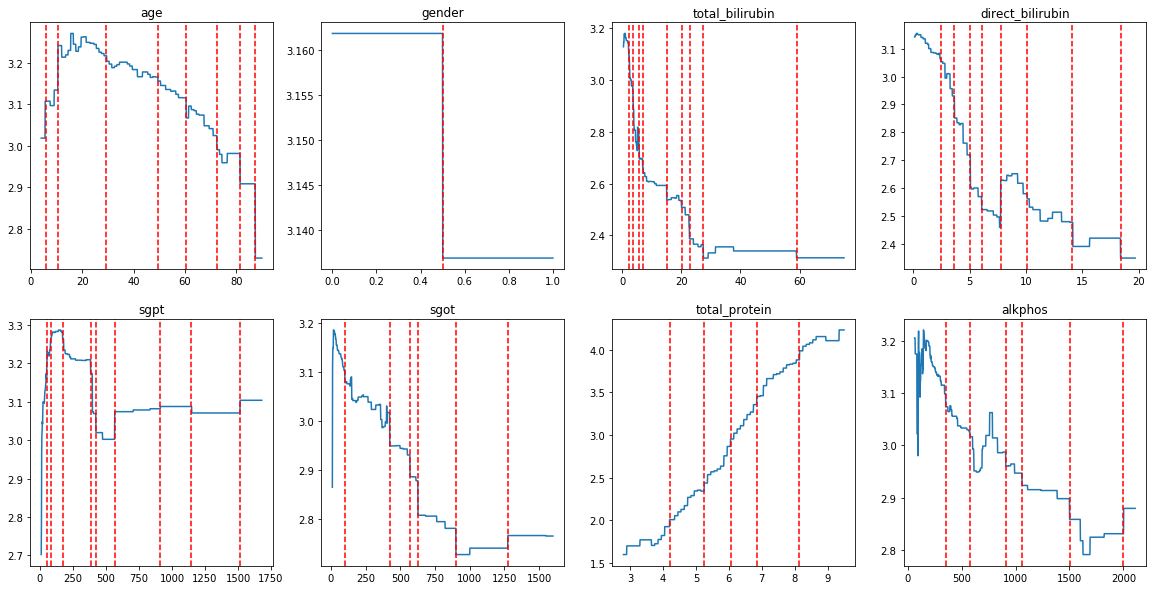

In [12]:
plt.figure(figsize=(20, 10))

for i, var in enumerate(variables, start=1):
    plt.subplot(2, 4, i)
    res, xs, chs, _ = results[var]
    plt.plot(xs, res, label='PDP')
    for ch in chs:
        plt.axvline(ch, c='red', ls='--', label='Breakpoints')
    plt.title(var)

plt.show()

### Creating new categorical features

In [13]:
X_train_cat = X_train.copy()
X_test_cat = X_test.copy()

for X_ in X_train_cat, X_test_cat:
    for var in variables:
        _, _, chs, _ = results[var]
        X_[f'{var}_cat'] = X_[var].apply(lambda x: bisect.bisect(chs, x))

## Lasso on enriched dataset

In [14]:
regr_lin_enh = Pipeline([
    ('mapper', DataFrameMapper(
        [([var], Normalizer()) for var in variables] + [(var + '_cat', LabelBinarizer()) for var in variables]
    )),
    ('regr', LassoCV(cv=3, random_state=0))
])

regr_lin_enh.fit(X_train_cat, y_train)

Pipeline(memory=None,
     steps=[('mapper', DataFrameMapper(default=False, df_out=False,
        features=[(['age'], Normalizer(copy=True, norm='l2')), (['gender'], Normalizer(copy=True, norm='l2')), (['total_bilirubin'], Normalizer(copy=True, norm='l2')), (['direct_bilirubin'], Normalizer(copy=True, norm='l2')), (['sgpt'], ...itive=False, precompute='auto', random_state=0, selection='cyclic',
    tol=0.0001, verbose=False))])

In [15]:
y_pred_lin_enh = regr_lin_enh.predict(X_test_cat)

mse = mean_squared_error(y_test, y_pred_lin_enh)
models['lasso_enriched'] = {'MSE': mse}
mse

0.22539144740972006

## Linear regression on original dataset

In [16]:
regr_lin = Pipeline([
    ('normalizer', Normalizer()),
    ('regr', LassoCV(cv=3, random_state=0))
])

regr_lin.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('normalizer', Normalizer(copy=True, norm='l2')), ('regr', LassoCV(alphas=None, copy_X=True, cv=3, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
    positive=False, precompute='auto', random_state=0, selection='cyclic',
    tol=0.0001, verbose=False))])

In [17]:
y_pred_lin = regr_lin.predict(X_test)

mse = mean_squared_error(y_test, y_pred_lin)
models['lasso'] = {'MSE': mse}
mse

0.36008142132500903

## Conclusion

In [18]:
models = pd.DataFrame(models)
models = models.transpose().sort_values('MSE')
models['Difference'] = models.diff()
models

,MSE,Difference
catboost,0.196308,NaN
lightgbm,0.197785,0.001477
lasso_enriched,0.225391,0.027607
lasso,0.360081,0.134690


Difference in MSE between CatBoost model and LightGBM model are negligible. 

Lasso on enriched dataset is very close to these two best models.

Data enrichment using SAFE method provides large improvement in performance of Lasso model while maintaining interpretability.